# Test validity step 3 : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$ becoming $P(r | ...) \propto s_c^t C(r)^{-1} s_c + ln|C(r)|$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


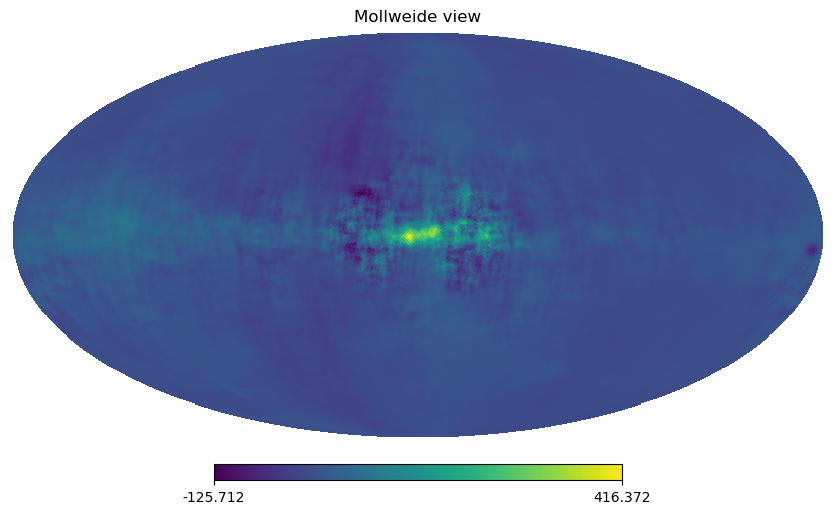

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, n_pix

In [5]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v8_JZ/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'biased_cutsky_v1b.toml'

In [6]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [7]:
MICMAC_sampler_obj.r_true

0.01

In [8]:
apod_mask = hp.ud_grade(hp.read_map("/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"), nside_out=MICMAC_sampler_obj.nside)

mask = np.copy(apod_mask)
mask[apod_mask>0] = 1
mask[apod_mask==0] = 0
template_mask = mask
MICMAC_sampler_obj.mask = mask

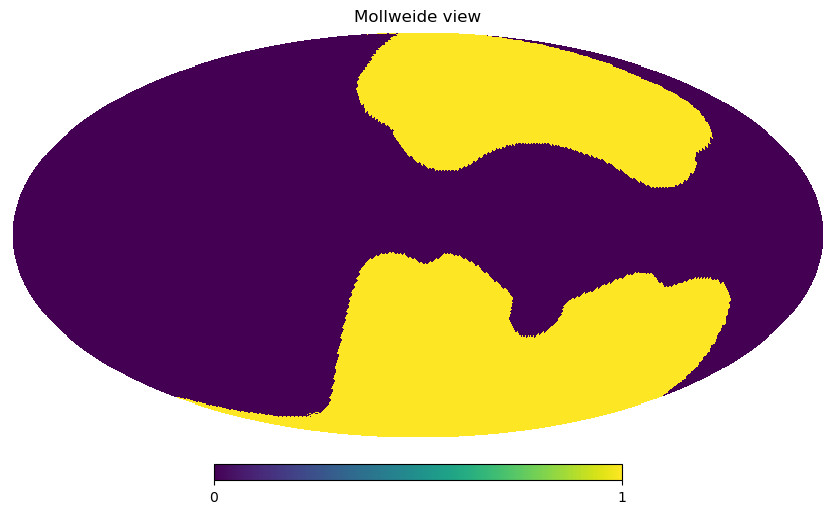

In [9]:
hp.mollview(mask)

In [10]:
reduction_noise = 1

In [11]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [12]:
freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_pix))

nb_pixels_mask = int(len(MICMAC_sampler_obj.mask[MICMAC_sampler_obj.mask!=0]))
freq_inverse_noise_masked[:,:,MICMAC_sampler_obj.mask!=0] = np.repeat(freq_inverse_noise.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.n_frequencies,MICMAC_sampler_obj.n_frequencies,nb_pixels_mask), order='C')

MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked*MICMAC_sampler_obj.mask
freq_inverse_noise = MICMAC_sampler_obj.freq_inverse_noise


In [13]:
# hp.mollview(MICMAC_sampler_obj.freq_inverse_noise[0,0])
# hp.mollview(MICMAC_sampler_obj.freq_inverse_noise[5,5])

In [14]:
instrument = get_instrument(instr_name)

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(MICMAC_sampler_obj.seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise)[:, 1:, :]   # keep only Q and U


In [15]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [16]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.n_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.n_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [17]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [18]:
input_freq_maps_masked = input_freq_maps*MICMAC_sampler_obj.mask

In [19]:
# s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps_masked, jax_use=False)[0, :, :]

In [20]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

In [21]:
red_cov_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix_jax(red_cov_matrix_sample)

In [22]:
s_cML.shape

(2, 49152)

In [23]:
PRNGKey = random.PRNGKey(0)
wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2c(s_cML, red_cov_matrix_sqrt, BtinvNB, initial_guess=jnp.empty(0))

map_random_realization_xi = None
map_random_realization_chi = None
fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps_v2c(red_cov_matrix_sqrt, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))

s_c_sample = wiener_filter_term + fluctuation_maps

CG-Python-0 Fluct finished with  lineax._solution.RESULTS<The maximum number of solver steps was reached. Try increasing `max_steps`.> {'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
Recalculating xi !
Recalculating chi !
CG Fluct finished in  9.525195121765137 seconds !!
CG-Python-0 Fluct finished with  lineax._solution.RESULTS<The maximum number of solver steps was reached. Try increasing `max_steps`.> {'max_steps': 200, 'num_steps': Array(200, dtype=int64)}


In [24]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter

In [25]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [26]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_87533/467683093.py:14: RuntimeWarning: invalid value encountered in divide
  analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


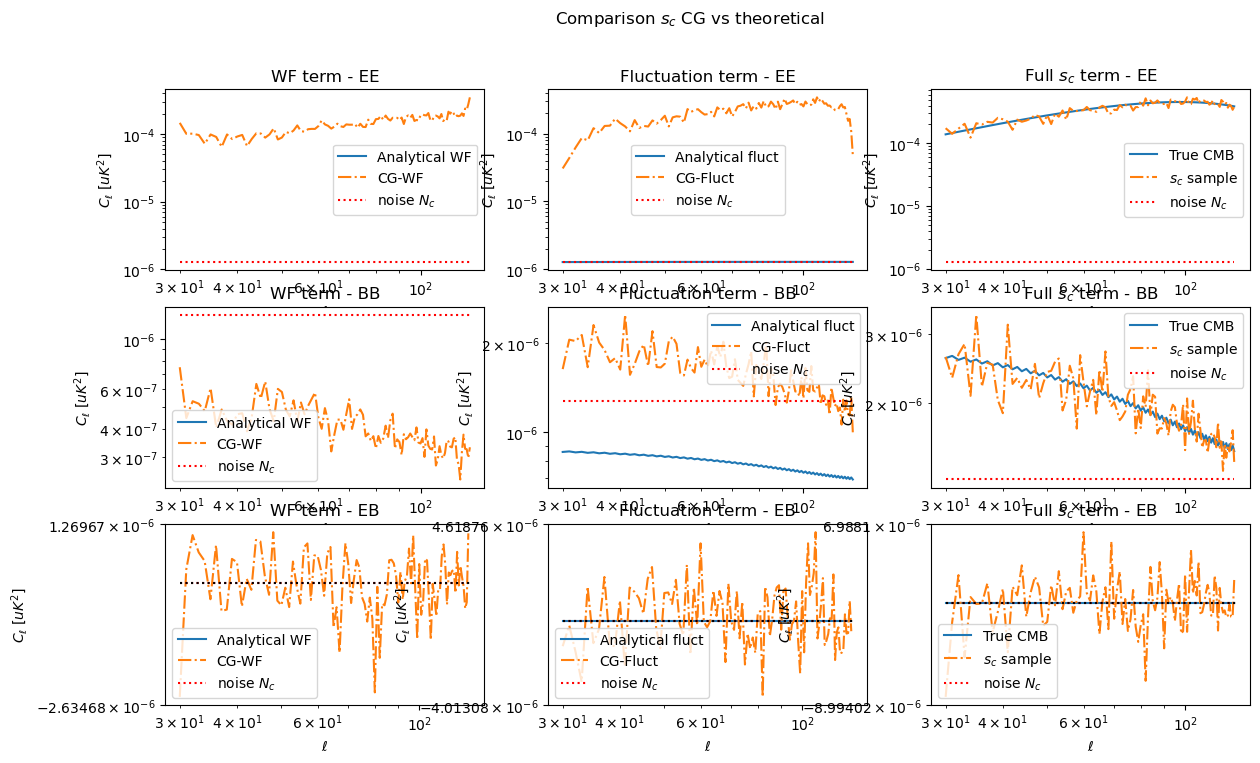

In [27]:
list_correl = ['EE', 'BB', 'EB']

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)


analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()

In [28]:
c_ells_true = jnp.zeros((3,lmax+1))
c_ells_true = c_ells_true.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

In [29]:
c_ells_Wishart = jnp.zeros((3,lmax+1))
c_ells_Wishart = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)
c_ells_Wishart = c_ells_Wishart.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

In [38]:
c_ells_Wishart_runs = jnp.zeros((3,lmax+1))
c_ells_Wishart_runs = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)
c_ells_Wishart_runs = c_ells_Wishart_runs.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

red_c_ells_Wishart_runs = get_reduced_matrix_from_c_ell(c_ells_Wishart_runs)

In [39]:
# MICMAC_sampler_obj.bin_ell_distributed_max = jnp.arange(MICMAC_sampler_obj.lmax+1)
# MICMAC_sampler_obj.bin_ell_distributed_min = jnp.arange(MICMAC_sampler_obj.lmax+1)


delta_ell = 10
nb_bin = (lmax-lmin+1)//delta_ell
# MICMAC_sampler_obj.bin_ell_distributed_max = MICMAC_sampler_obj.lmin + (jnp.arange(nb_bin)+1)*delta_ell - 1
MICMAC_sampler_obj.bin_ell_distribution = MICMAC_sampler_obj.lmin + jnp.arange(nb_bin+1)*delta_ell
MICMAC_sampler_obj.maximum_number_dof = int(MICMAC_sampler_obj.bin_ell_distribution[-1]**2 - MICMAC_sampler_obj.bin_ell_distribution[-2]**2)
MICMAC_sampler_obj.lmax_bin = MICMAC_sampler_obj.bin_ell_distribution[-1]
print(nb_bin)

9


In [40]:
MICMAC_sampler_obj.bin_ell_distribution[-1], MICMAC_sampler_obj.bin_ell_distribution[0]

(Array(120, dtype=int64), Array(30, dtype=int64))

In [49]:
red_test_c_ells_binned.shape

(90, 2, 2)

In [45]:
def get_binned_red_c_ells_v3(self, red_c_ells_to_bin):
    """ Bin the power spectrum to get the binned power spectrum
        
            Parameters
            ----------
            :param red_c_ells_to_bin: power spectrum to bin ; must be of dimension [lmax+1, nstokes, nstokes]

            Returns
            -------
            :return: Binned power spectrum, of dimension [number_bins, nstokes, nstokes]
    """
    chx.assert_axis_dimension(red_c_ells_to_bin, 0, self.lmax+1 - self.lmin)

    ell_distribution = jnp.arange(red_c_ells_to_bin.shape[0]) + self.lmin

    # number_bins = self.bin_ell_distribution.shape[0]-1

    def map_binned_red_c_ells(bin_ell):
        """ Compute the binned power spectrum for a given ell
        """
        cond = jnp.logical_and(self.bin_ell_distribution[bin_ell]<=ell_distribution, self.bin_ell_distribution[bin_ell+1]>ell_distribution)
        cond_quantitative = jnp.where(cond, 1, 0)
        modes_to_bin = jnp.einsum('lij, l->lij', red_c_ells_to_bin, cond_quantitative)

        return modes_to_bin.sum(axis=0)#/(self.bin_ell_distribution[bin_ell+1]-self.bin_ell_distribution[bin_ell])

    binned_red_c_ells = jax.vmap(map_binned_red_c_ells)(jnp.arange(self.number_bins))
    return binned_red_c_ells


In [48]:
red_test_c_ells_binned[-10:]

Array([[[4.69882153e-03, 0.00000000e+00],
        [0.00000000e+00, 1.74293893e-05]],

       [[4.61491401e-03, 0.00000000e+00],
        [0.00000000e+00, 1.71181502e-05]],

       [[4.53323411e-03, 0.00000000e+00],
        [0.00000000e+00, 1.68151741e-05]],

       [[4.45370369e-03, 0.00000000e+00],
        [0.00000000e+00, 1.65201710e-05]],

       [[4.37624797e-03, 0.00000000e+00],
        [0.00000000e+00, 1.62328637e-05]],

       [[4.30079542e-03, 0.00000000e+00],
        [0.00000000e+00, 1.59529867e-05]],

       [[4.22727755e-03, 0.00000000e+00],
        [0.00000000e+00, 1.56802861e-05]],

       [[4.15562878e-03, 0.00000000e+00],
        [0.00000000e+00, 1.54145185e-05]],

       [[4.08578628e-03, 0.00000000e+00],
        [0.00000000e+00, 1.51554510e-05]],

       [[4.01768984e-03, 0.00000000e+00],
        [0.00000000e+00, 1.49028602e-05]]], dtype=float64)

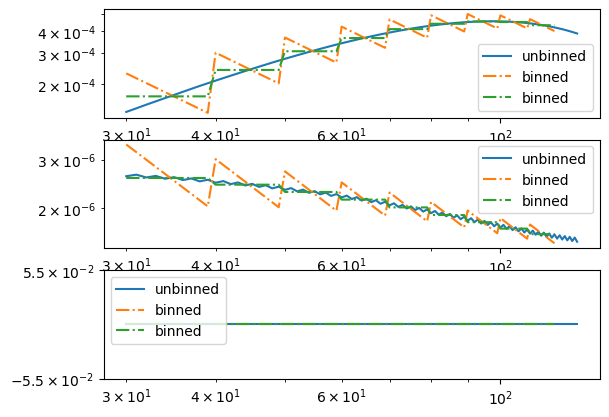

In [47]:
test_c_ells_unbinned = micmac.get_c_ells_from_red_covariance_matrix_JAX(red_c_ells_Wishart_runs)[:,MICMAC_sampler_obj.lmin:]
_test_c_ells_binned = micmac.get_c_ells_from_red_covariance_matrix_JAX(get_binned_red_c_ells_v2(MICMAC_sampler_obj, red_c_ells_Wishart_runs[MICMAC_sampler_obj.lmin:]))
_test_c_ells_binned_2 = micmac.get_c_ells_from_red_covariance_matrix_JAX(get_binned_red_c_ells_v3(MICMAC_sampler_obj, red_c_ells_Wishart_runs[MICMAC_sampler_obj.lmin:]))
red_test_c_ells_binned = micmac.get_reduced_matrix_from_c_ell(_test_c_ells_binned)
red_test_c_ells_binned_2 = micmac.get_reduced_matrix_from_c_ell(_test_c_ells_binned_2)

def reconstruct_spectra(ell):
    cond = jnp.logical_and(MICMAC_sampler_obj.bin_ell_distribution[:-1]<=ell, MICMAC_sampler_obj.bin_ell_distribution[1:]>ell)
    bin_contribution = jnp.where(cond, 1, 0)
    return jnp.einsum('lij,l->ij',red_test_c_ells_binned,bin_contribution)/(ell*(ell+1))

def reconstruct_spectra_2(ell):
    cond = jnp.logical_and(MICMAC_sampler_obj.bin_ell_distribution[:-1]<=ell, MICMAC_sampler_obj.bin_ell_distribution[1:]>ell)
    bin_contribution = jnp.where(cond, 1, 0)
    return jnp.einsum('lij,l->ij',red_test_c_ells_binned_2,bin_contribution)#/(ell*(ell+1))

# red_test_c_ells_binned = jax.vmap(reconstruct_spectra)(jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1))
red_test_c_ells_binned = jax.vmap(reconstruct_spectra)(jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax_bin))
test_c_ells_binned = micmac.get_c_ells_from_red_covariance_matrix_JAX(red_test_c_ells_binned)

red_test_c_ells_binned_2 = jax.vmap(reconstruct_spectra_2)(jnp.arange(MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax_bin))
test_c_ells_binned_2 = micmac.get_c_ells_from_red_covariance_matrix_JAX(red_test_c_ells_binned_2)

for j in range(nstokes+1):
    plt.subplot(311+j)
    plt.plot(np.arange(test_c_ells_unbinned.shape[-1])+lmin, test_c_ells_unbinned[j,:], label='unbinned')
    # plt.plot(np.arange(test_c_ells_binned.shape[-1])*delta_ell + (delta_ell-1)/2 + lmin, test_c_ells_binned[j,:], '-.', label='binned')
    plt.plot(np.arange(test_c_ells_binned.shape[-1])+lmin, test_c_ells_binned[j,:]/delta_ell, '-.', label='binned')
    plt.plot(np.arange(test_c_ells_binned.shape[-1])+lmin, test_c_ells_binned_2[j,:]/delta_ell, '-.', label='binned')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        # plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.legend()
plt.show()

In [ ]:
test_c_ells_binned_v2

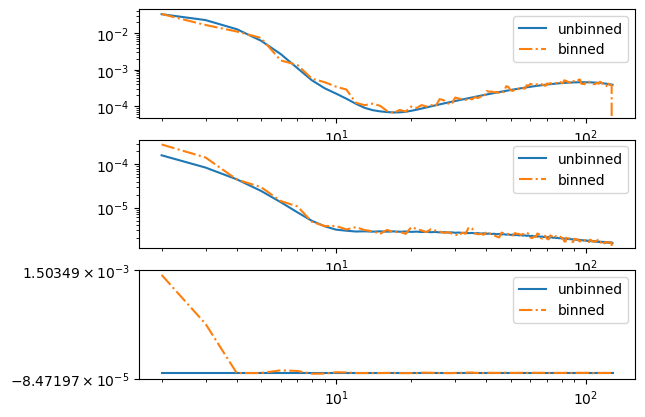

In [ ]:
test_c_ells_unbinned_v2 = micmac.get_c_ells_from_red_covariance_matrix_JAX(red_c_ells_Wishart_runs)[:,MICMAC_sampler_obj.lmin:]
test_c_ells_binned_v2 = micmac.get_c_ells_from_red_covariance_matrix_JAX(jitted_get_binned_inverse_wishart_sampling_from_c_ells_v2(c_ells_Wishart_runs[:,lmin:], PRNGKey))


for j in range(nstokes+1):
    plt.subplot(311+j)
    plt.plot(np.arange(test_c_ells_unbinned_v2.shape[-1])+lmin, test_c_ells_unbinned_v2[j,:], label='unbinned')
    plt.plot(np.arange(test_c_ells_binned_v2.shape[-1]) + lmin, test_c_ells_binned_v2[j,:], '-.', label='binned')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        # plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.legend()
plt.show()

In [ ]:
MICMAC_sampler_obj.bin_ell_distribution

Array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129],      dtype=int64)

(127, 2, 2)

In [ ]:
PRNGKey = random.PRNGKey(42)

In [ ]:
%%time 
red_invWishart_cells = MICMAC_sampler_obj.get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart, PRNGKey)

CPU times: user 1.34 s, sys: 26.8 ms, total: 1.36 s
Wall time: 1.39 s


In [ ]:
jitted_get_inverse_wishart_sampling_from_c_ells = jax.jit(MICMAC_sampler_obj.get_inverse_wishart_sampling_from_c_ells)

In [ ]:
%%time
red_invWishart_cells_ = jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart, PRNGKey)

CPU times: user 415 ms, sys: 9.97 ms, total: 425 ms
Wall time: 421 ms


In [ ]:
%%time
red_invWishart_cells_ = jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart, PRNGKey)

CPU times: user 5.78 ms, sys: 2 ms, total: 7.78 ms
Wall time: 2.61 ms


In [ ]:
%%time
red_invWishart_cells_ = jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart, PRNGKey+1)

CPU times: user 5.57 ms, sys: 2.16 ms, total: 7.72 ms
Wall time: 3.04 ms


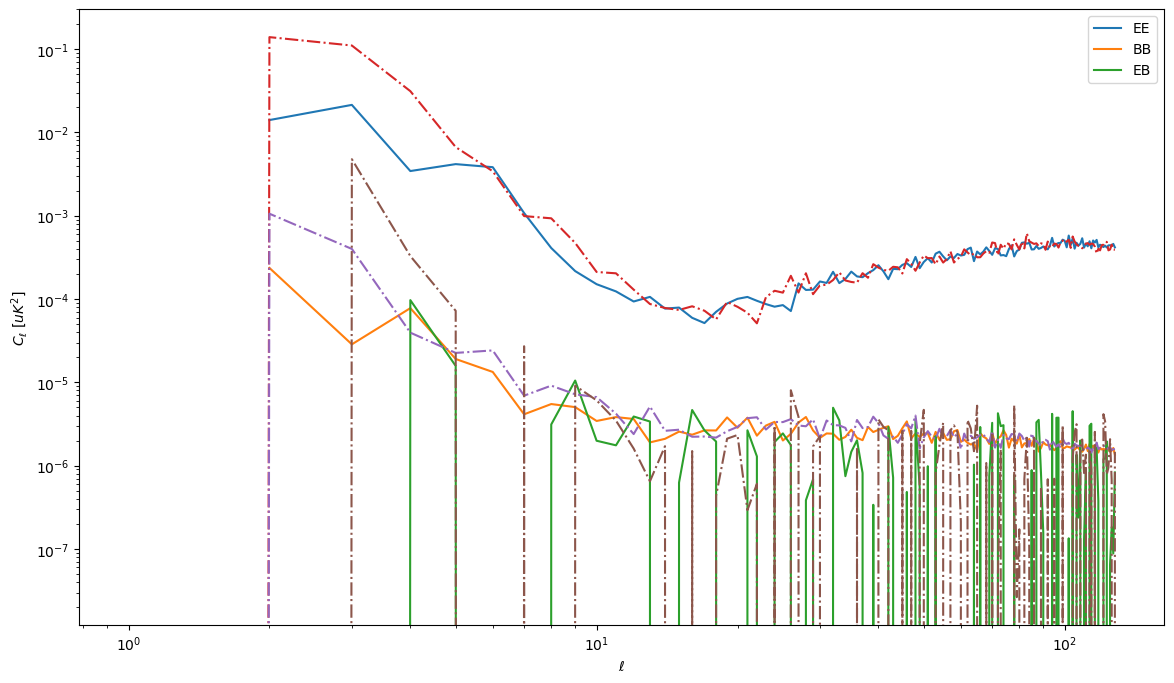

In [ ]:
c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells)

plt.figure(figsize=(14,8))
plt.plot(np.arange(c_ell_results.shape[-1])[lmin:], c_ell_true_CMB.T)
plt.plot(np.arange(c_ell_results.shape[-1]), c_ell_results.T, '-.')
plt.loglog()
plt.legend(['EE', 'BB', 'EB'])
plt.xlabel(r"$\ell$")
plt.ylabel("$C_\ell$ [$uK^2$]")
plt.show()

In [50]:
def get_binned_red_c_ells_v2(self, red_c_ells_to_bin):
    """ Bin the power spectrum to get the binned power spectrum
        
            Parameters
            ----------
            :param red_c_ells_to_bin: power spectrum to bin ; must be of dimension [lmax+1, nstokes, nstokes]

            Returns
            -------
            :return: Binned power spectrum, of dimension [number_bins, nstokes, nstokes]
    """
    chx.assert_axis_dimension(red_c_ells_to_bin, 0, self.lmax+1 - self.lmin)

    ell_distribution = jnp.arange(red_c_ells_to_bin.shape[0]) + self.lmin

    # number_bins = self.bin_ell_distribution.shape[0]-1

    def map_binned_red_c_ells(bin_ell):
        """ Compute the binned power spectrum for a given ell
        """
        cond = jnp.logical_and(self.bin_ell_distribution[bin_ell]<=ell_distribution, self.bin_ell_distribution[bin_ell+1]>ell_distribution)
        cond_quantitative = jnp.where(cond, 1, 0)
        modes_to_bin = jnp.einsum('lij, l, l->lij', red_c_ells_to_bin, cond_quantitative, ell_distribution*(ell_distribution+1))

        return modes_to_bin.sum(axis=0)#/(self.bin_ell_distribution[bin_ell+1]-self.bin_ell_distribution[bin_ell])

    binned_red_c_ells = jax.vmap(map_binned_red_c_ells)(jnp.arange(self.number_bins))
    return binned_red_c_ells


def get_binned_inverse_wishart_sampling_from_c_ells_v2(self, sigma_ell, PRNGKey, old_sample=None, acceptance_posdef=False):
    """ Solve sampling step 3 : inverse Wishart distribution with C

        sigma_ell is expected to be exactly the parameter of the inverse Wishart (so it should NOT be multiplied by 2*ell+1 if it is thought as a power spectrum)

        Compute a matrix sample following an inverse Wishart distribution. The 3 steps follow Gupta & Nagar (2000) :
            1. Sample n = 2*ell - p + 2*q_prior independent Gaussian vectors with covariance (sigma_ell)^{-1}
            2. Compute their outer product to form a matrix of dimension n_stokes*n_stokes ; which gives us a sample following the Wishart distribution
            3. Invert this matrix to obtain the final result : a matrix sample following an inverse Wishart distribution

        Also assumes the monopole and dipole to be 0

        Parameters
        ----------
        :param sigma_ell: initial power spectrum which will define the parameter matrix of the inverse Wishart distribution ; must be of dimension [number_correlations, lmax+1]
        :param PRNGKey: random key for JAX PNRG
        
        Returns
        -------
        :return: Matrices following an inverse Wishart distribution, of dimensions [lmin:lmax, nstokes, nstokes]
    """

    # chx.assert_axis_dimension(sigma_ell, 1, self.lmax+1)
    chx.assert_axis_dimension(sigma_ell, 1, self.lmax+1-self.lmin)
    # c_ells_Wishart_modified = jnp.copy(sigma_ell)*(2*jnp.arange(self.lmax+1) + 1)
    c_ells_Wishart_modified = jnp.copy(sigma_ell)*(2*(jnp.arange(self.lmax+1-self.lmin)+self.lmin) + 1)
    # invert_parameter_Wishart = jnp.linalg.pinv(get_reduced_matrix_from_c_ell_jax(c_ells_Wishart_modified))
    binned_invert_parameter_Wishart = jnp.linalg.pinv(self.get_binned_red_c_ells_v2(get_reduced_matrix_from_c_ell_jax(c_ells_Wishart_modified)))

    # sampling_Wishart = jnp.zeros_like(invert_parameter_Wishart)
    sampling_Wishart = jnp.zeros_like(binned_invert_parameter_Wishart)
    # number_dof = lambda x: 2*x+1

    def map_sampling_Wishart(ell_PNRGKey, binned_ell):
        """ Compute the sampling of the Wishart distribution for a given ell
        """

        sample_gaussian = random.multivariate_normal(ell_PNRGKey, jnp.zeros(self.nstokes), binned_invert_parameter_Wishart[binned_ell], shape=(self.maximum_number_dof - self.nstokes-1,))

        weighting = jnp.where(self.number_dof(binned_ell)-self.nstokes-1 >= jnp.arange(self.maximum_number_dof-self.nstokes-1), 1, 0)

        sample_to_return = jnp.einsum('lk,l,lm->km',sample_gaussian,weighting,sample_gaussian)
        # new_carry = new_ell_PRNGKey
        return sample_to_return

    # distribution_bins_over_lmin = self.bin_ell_distributed_min[self.bin_ell_distributed_min>=self.lmin]
    distribution_bins_over_lmin = jnp.copy(self.bin_ell_distribution)[:-1]

    # number_bins_over_lmin = distribution_bins_over_lmin.shape[0]
    # number_bins_over_lmin = jnp.size(distribution_bins_over_lmin)

    # PRNGKey_map = random.split(PRNGKey, self.lmax-self.lmin+1) # Prepare lmax+1-lmin PRNGKeys to be used
    PRNGKey_map = random.split(PRNGKey, self.number_bins) # Prepare lmax+1-lmin PRNGKeys to be used

    # sampling_Wishart_map = jax.vmap(map_sampling_Wishart)(PRNGKey_map, jnp.arange(self.lmin,self.lmax+1))
    sampling_Wishart_map = jax.vmap(map_sampling_Wishart)(PRNGKey_map, jnp.arange(self.number_bins))
    # Map over PRNGKeys and ells to create samples of the Wishart distribution, of dimension [lmax+1-lmin,nstokes,nstokes]

    sampling_Wishart = sampling_Wishart.at[-self.number_bins:].set(sampling_Wishart_map)
    sampling_invWishart = jnp.linalg.pinv(sampling_Wishart)

    def reconstruct_spectra(ell):
        cond = jnp.logical_and(self.bin_ell_distribution[:-1]<=ell, self.bin_ell_distribution[1:]>ell)
        bin_contribution = jnp.where(cond, 1, 0)
        return jnp.einsum('lij,l->ij',sampling_invWishart,bin_contribution)/(ell*(ell+1))
    
    # reconstructed_spectra = jax.vmap(reconstruct_spectra)(jnp.arange(self.lmin,self.lmax+1))
    reconstructed_spectra = jax.vmap(reconstruct_spectra)(jnp.arange(self.lmin,self.bin_ell_distribution[-1]))

    if acceptance_posdef:
        print("Only positive definite matrices are accepted for inv Wishart !")
        eigen_prod = jnp.prod(jnp.linalg.eigvalsh(reconstructed_spectra), axis=(1))
        acceptance = jnp.where(eigen_prod<0, 0, 1)
        acceptance_reversed = jnp.where(eigen_prod<0, 1, 0)
        # new_sample = jnp.copy(old_sample)
        # new_sample = new_sample.at[acceptance==1,...].set(reconstructed_spectra[acceptance==1,...])
        new_sample = jnp.einsum('lik,l->lik', reconstructed_spectra, acceptance) + jnp.einsum('lik,l->lik', old_sample, acceptance_reversed)

    chx.assert_tree_all_finite(new_sample)
    return new_sample
    # return reconstructed_spectra

def get_binned_red_c_ells_v3(self, red_c_ells_to_bin):
    """ Bin the power spectrum to get the binned power spectrum
        
            Parameters
            ----------
            :param red_c_ells_to_bin: power spectrum to bin ; must be of dimension [lmax+1, nstokes, nstokes]

            Returns
            -------
            :return: Binned power spectrum, of dimension [number_bins, nstokes, nstokes]
    """
    chx.assert_axis_dimension(red_c_ells_to_bin, 0, self.lmax+1 - self.lmin)

    ell_distribution = jnp.arange(red_c_ells_to_bin.shape[0]) + self.lmin

    # number_bins = self.bin_ell_distribution.shape[0]-1

    def map_binned_red_c_ells(bin_ell):
        """ Compute the binned power spectrum for a given ell
        """
        cond = jnp.logical_and(self.bin_ell_distribution[bin_ell]<=ell_distribution, self.bin_ell_distribution[bin_ell+1]>ell_distribution)
        cond_quantitative = jnp.where(cond, 1, 0)
        modes_to_bin = jnp.einsum('lij, l->lij', red_c_ells_to_bin, cond_quantitative)

        return modes_to_bin.sum(axis=0)#/(self.bin_ell_distribution[bin_ell+1]-self.bin_ell_distribution[bin_ell])

    binned_red_c_ells = jax.vmap(map_binned_red_c_ells)(jnp.arange(self.number_bins))
    return binned_red_c_ells

def get_binned_red_c_ells_v3b(red_c_ells_to_bin):
    """ Bin the power spectrum to get the binned power spectrum
        
            Parameters
            ----------
            :param red_c_ells_to_bin: power spectrum to bin ; must be of dimension [lmax+1, nstokes, nstokes]

            Returns
            -------
            :return: Binned power spectrum, of dimension [number_bins, nstokes, nstokes]
    """
    chx.assert_axis_dimension(red_c_ells_to_bin, 0, MICMAC_sampler_obj.lmax+1 - MICMAC_sampler_obj.lmin)

    ell_distribution = jnp.arange(red_c_ells_to_bin.shape[0]) + MICMAC_sampler_obj.lmin

    # number_bins = self.bin_ell_distribution.shape[0]-1

    def map_binned_red_c_ells(bin_ell):
        """ Compute the binned power spectrum for a given ell
        """
        cond = jnp.logical_and(MICMAC_sampler_obj.bin_ell_distribution[bin_ell]<=ell_distribution, MICMAC_sampler_obj.bin_ell_distribution[bin_ell+1]>ell_distribution)
        cond_quantitative = jnp.where(cond, 1, 0)
        modes_to_bin = jnp.einsum('lij, l->lij', red_c_ells_to_bin, cond_quantitative)

        return modes_to_bin.sum(axis=0)#/(self.bin_ell_distribution[bin_ell+1]-self.bin_ell_distribution[bin_ell])

    binned_red_c_ells = jax.vmap(map_binned_red_c_ells)(jnp.arange(MICMAC_sampler_obj.number_bins))
    return binned_red_c_ells


def get_binned_inverse_wishart_sampling_from_c_ells_v3(self, sigma_ell, PRNGKey, old_sample=None, acceptance_posdef=False):
    """ Solve sampling step 3 : inverse Wishart distribution with C

        sigma_ell is expected to be exactly the parameter of the inverse Wishart (so it should NOT be multiplied by 2*ell+1 if it is thought as a power spectrum)

        Compute a matrix sample following an inverse Wishart distribution. The 3 steps follow Gupta & Nagar (2000) :
            1. Sample n = 2*ell - p + 2*q_prior independent Gaussian vectors with covariance (sigma_ell)^{-1}
            2. Compute their outer product to form a matrix of dimension n_stokes*n_stokes ; which gives us a sample following the Wishart distribution
            3. Invert this matrix to obtain the final result : a matrix sample following an inverse Wishart distribution

        Also assumes the monopole and dipole to be 0

        Parameters
        ----------
        :param sigma_ell: initial power spectrum which will define the parameter matrix of the inverse Wishart distribution ; must be of dimension [number_correlations, lmax+1]
        :param PRNGKey: random key for JAX PNRG
        
        Returns
        -------
        :return: Matrices following an inverse Wishart distribution, of dimensions [lmin:lmax, nstokes, nstokes]
    """

    # chx.assert_axis_dimension(sigma_ell, 1, self.lmax+1)
    chx.assert_axis_dimension(sigma_ell, 1, self.lmax+1-self.lmin)
    # c_ells_Wishart_modified = jnp.copy(sigma_ell)*(2*jnp.arange(self.lmax+1) + 1)
    c_ells_Wishart_modified = jnp.copy(sigma_ell)*(2*(jnp.arange(self.lmax+1-self.lmin)+self.lmin) + 1)
    # invert_parameter_Wishart = jnp.linalg.pinv(get_reduced_matrix_from_c_ell_jax(c_ells_Wishart_modified))
    binned_invert_parameter_Wishart = jnp.linalg.pinv(self.get_binned_red_c_ells_v3(get_reduced_matrix_from_c_ell_jax(c_ells_Wishart_modified)))

    # sampling_Wishart = jnp.zeros_like(invert_parameter_Wishart)
    sampling_Wishart = jnp.zeros_like(binned_invert_parameter_Wishart)
    # number_dof = lambda x: 2*x+1

    def map_sampling_Wishart(ell_PNRGKey, binned_ell):
        """ Compute the sampling of the Wishart distribution for a given ell
        """

        sample_gaussian = random.multivariate_normal(ell_PNRGKey, jnp.zeros(self.nstokes), binned_invert_parameter_Wishart[binned_ell], shape=(self.maximum_number_dof - self.nstokes-1,))

        weighting = jnp.where(self.number_dof(binned_ell)-self.nstokes-1 >= jnp.arange(self.maximum_number_dof-self.nstokes-1), 1, 0)

        sample_to_return = jnp.einsum('lk,l,lm->km',sample_gaussian,weighting,sample_gaussian)
        # new_carry = new_ell_PRNGKey
        return sample_to_return

    # distribution_bins_over_lmin = self.bin_ell_distributed_min[self.bin_ell_distributed_min>=self.lmin]
    distribution_bins_over_lmin = jnp.copy(self.bin_ell_distribution)[:-1]

    # number_bins_over_lmin = distribution_bins_over_lmin.shape[0]
    # number_bins_over_lmin = jnp.size(distribution_bins_over_lmin)

    # PRNGKey_map = random.split(PRNGKey, self.lmax-self.lmin+1) # Prepare lmax+1-lmin PRNGKeys to be used
    PRNGKey_map = random.split(PRNGKey, self.number_bins) # Prepare lmax+1-lmin PRNGKeys to be used

    # sampling_Wishart_map = jax.vmap(map_sampling_Wishart)(PRNGKey_map, jnp.arange(self.lmin,self.lmax+1))
    sampling_Wishart_map = jax.vmap(map_sampling_Wishart)(PRNGKey_map, jnp.arange(self.number_bins))
    # Map over PRNGKeys and ells to create samples of the Wishart distribution, of dimension [lmax+1-lmin,nstokes,nstokes]

    sampling_Wishart = sampling_Wishart.at[-self.number_bins:].set(sampling_Wishart_map)
    sampling_invWishart = jnp.linalg.pinv(sampling_Wishart)

    def reconstruct_spectra(ell):
        cond = jnp.logical_and(self.bin_ell_distribution[:-1]<=ell, self.bin_ell_distribution[1:]>ell)
        bin_contribution = jnp.where(cond, 1, 0)
        # return jnp.einsum('lij,l->ij',sampling_invWishart,bin_contribution)#/(ell*(ell+1))
        return jnp.einsum('lij,l->ij',sampling_invWishart,bin_contribution)/bin_contribution.sum()
    
    # reconstructed_spectra = jax.vmap(reconstruct_spectra)(jnp.arange(self.lmin,self.lmax+1))
    reconstructed_spectra = jax.vmap(reconstruct_spectra)(jnp.arange(self.lmin,self.bin_ell_distribution[-1]))
    
    new_sample = reconstructed_spectra
    if acceptance_posdef:
        print("Only positive definite matrices are accepted for inv Wishart !")
        eigen_prod = jnp.prod(jnp.linalg.eigvalsh(reconstructed_spectra), axis=(1))
        acceptance = jnp.where(eigen_prod<0, 0, 1)
        acceptance_reversed = jnp.where(eigen_prod<0, 1, 0)
        # new_sample = jnp.copy(old_sample)
        # new_sample = new_sample.at[acceptance==1,...].set(reconstructed_spectra[acceptance==1,...])
        new_sample = jnp.einsum('lik,l->lik', reconstructed_spectra, acceptance) + jnp.einsum('lik,l->lik', old_sample, acceptance_reversed)

    chx.assert_tree_all_finite(new_sample)
    return new_sample
    # return reconstructed_spectra


In [51]:
MICMAC_sampler_obj.get_binned_red_c_ells_v3 = get_binned_red_c_ells_v3b

# Tests larger scale

In [52]:
# jitted_get_binned_inverse_wishart_sampling_from_c_ells = jax.jit(get_binned_inverse_wishart_sampling_from_c_ells_v2)
# jitted_get_binned_inverse_wishart_sampling_from_c_ells = jax.jit(get_binned_inverse_wishart_sampling_from_c_ells_v3)

In [95]:
c_ells_Wishart_runs = jnp.zeros((3,lmax+1))
c_ells_Wishart_runs = micmac.get_cell_from_map_jax(s_c_sample, lmax=MICMAC_sampler_obj.lmax, n_iter=MICMAC_sampler_obj.n_iter)
# c_ells_Wishart_runs = c_ells_Wishart_runs.at[:,:lmin].set(0)
c_ells_Wishart_runs = c_ells_Wishart_runs.at[:,lmin:].set(micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor))

red_c_ells_Wishart_runs = get_reduced_matrix_from_c_ell(c_ells_Wishart_runs)

In [54]:
nb_simus = 700

In [55]:
%%time 
PRNGKey = random.PRNGKey(42)

red_invWishart_cells_list = jnp.zeros((nb_simus,lmax+1,nstokes,nstokes))
for i in range(nb_simus):
    PRNGKey, subkey = random.split(PRNGKey)
    # red_invWishart_cells_list = red_invWishart_cells_list.at[i].set(jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart_runs, PRNGKey))
    # red_invWishart_cells_list = red_invWishart_cells_list.at[i,lmin:,...].set(jitted_get_binned_inverse_wishart_sampling_from_c_ells(c_ells_Wishart_runs[:,lmin:], PRNGKey))
    # red_invWishart_cells_list = red_invWishart_cells_list.at[i,lmin:MICMAC_sampler_obj.bin_ell_distribution[-1],...].set(get_binned_inverse_wishart_sampling_from_c_ells_v3(MICMAC_sampler_obj, c_ells_Wishart_runs[:,lmin:], PRNGKey))
    red_invWishart_cells_list = red_invWishart_cells_list.at[i,lmin:,...].set(MICMAC_sampler_obj.get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart_runs[:,lmin:], PRNGKey, acceptance_posdef=True))


CPU times: user 15.1 s, sys: 549 ms, total: 15.6 s
Wall time: 14.1 s


In [56]:
%%time 

# delta_ell = 2
# nb_bin = (lmax-lmin+1)//delta_ell
# MICMAC_sampler_obj.bin_ell_distribution = MICMAC_sampler_obj.lmin + jnp.arange(nb_bin+1)*delta_ell

# number_dof = lambda x: (MICMAC_sampler_obj.bin_ell_distribution[x+1])**2 - MICMAC_sampler_obj.bin_ell_distribution[x]**2
# # max_number_dof = number_dof(MICMAC_sampler_obj.lmax-MICMAC_sampler_obj.lmin)
# max_number_dof = number_dof(-2)
# MICMAC_sampler_obj.maximum_number_dof = int(max_number_dof)

PRNGKey = random.PRNGKey(42)

red_invWishart_binned_cells_list = jnp.zeros((nb_simus,lmax+1,nstokes,nstokes))
for i in range(nb_simus):
    PRNGKey, subkey = random.split(PRNGKey)
    # red_invWishart_cells_list = red_invWishart_cells_list.at[i].set(jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart_runs, PRNGKey))
    # red_invWishart_binned_cells_list = red_invWishart_binned_cells_list.at[i].set(jitted_get_binned_inverse_wishart_sampling_from_c_ells(c_ells_Wishart_runs[:,lmin:], PRNGKey))
    red_invWishart_binned_cells_list = red_invWishart_binned_cells_list.at[i,lmin:MICMAC_sampler_obj.bin_ell_distribution[-1],...].set(get_binned_inverse_wishart_sampling_from_c_ells_v3(MICMAC_sampler_obj, c_ells_Wishart_runs[:,lmin:], PRNGKey))


CPU times: user 23.2 s, sys: 530 ms, total: 23.7 s
Wall time: 22.2 s


In [370]:
%%time 

delta_ell = 2
nb_bin = (lmax-lmin+1)//delta_ell
MICMAC_sampler_obj.bin_ell_distribution = MICMAC_sampler_obj.lmin + jnp.arange(nb_bin+1)*delta_ell

number_dof = lambda x: (MICMAC_sampler_obj.bin_ell_distribution[x+1])**2 - MICMAC_sampler_obj.bin_ell_distribution[x]**2
# max_number_dof = number_dof(MICMAC_sampler_obj.lmax-MICMAC_sampler_obj.lmin)
max_number_dof = number_dof(-2)
MICMAC_sampler_obj.maximum_number_dof = int(max_number_dof)

PRNGKey = random.PRNGKey(42)

red_invWishart_binned_cells_list_v2 = jnp.zeros((nb_simus,MICMAC_sampler_obj.lmax+1,nstokes,nstokes))
for i in range(nb_simus):
    PRNGKey, subkey = random.split(PRNGKey)
    # red_invWishart_cells_list = red_invWishart_cells_list.at[i].set(jitted_get_inverse_wishart_sampling_from_c_ells(c_ells_Wishart_runs, PRNGKey))
    red_invWishart_binned_cells_list_v2 = red_invWishart_binned_cells_list_v2.at[i,lmin:].set(jitted_get_binned_inverse_wishart_sampling_from_c_ells_v2(c_ells_Wishart_runs[:,lmin:], PRNGKey))


CPU times: user 4.1 s, sys: 506 ms, total: 4.61 s
Wall time: 2.45 s


In [79]:
mean_c_ell_results_binned[:,119]

array([4.34581926e-04, 1.61220709e-06, 2.77200716e-08])

In [82]:
ell_arange = np.arange(lmax+1)

mean_c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells_list.mean(axis=0))
mean_c_ell_results_binned = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list.mean(axis=0))
# mean_c_ell_results_binned_v2 = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list_v2.mean(axis=0))

# binned_ell = np.arange(mean_c_ell_results_binned.shape[-1])*delta_ell + (delta_ell-1)/2 + lmin
binned_ell = np.arange(mean_c_ell_results_binned.shape[-1])# + lmin

lmin_mean = 4
factor_ell = ((2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes))[lmin_mean:]

alpha_value = .5

plt.figure(figsize=(14,8))
for j in range(number_correl_to_plot):
    plt.subplot(311+j)    
    
    c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells_list[0,...])
    plt.plot(ell_arange, c_ell_results[j,:], alpha=alpha_value, color='navajowhite', label='Samples')
    for k in range(1,nb_simus):
        c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells_list[k,...])
        plt.plot(ell_arange, c_ell_results[j,:], color='navajowhite', alpha=alpha_value)

    
    c_ell_results_binned = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list[0,...])#[...,lmin:]
    plt.plot(binned_ell, c_ell_results_binned[j,:], alpha=alpha_value, color='orchid', label='Samples binned')
    for k in range(1,nb_simus):
        c_ell_results_binned = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list[k,...])#[...,lmin:]
        plt.plot(binned_ell, c_ell_results_binned[j,:], color='orchid', alpha=alpha_value)
    
    # c_ell_results_binned_v2 = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list_v2[0,...])
    # plt.plot(ell_arange, c_ell_results_binned_v2[j,:], alpha=alpha_value, color='darksalmon', label='Samples binned v2')
    # for k in range(1,nb_simus):
    #     c_ell_results_binned_v2 = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list_v2[k,...])#[...,lmin:]
    #     plt.plot(ell_arange, c_ell_results_binned_v2[j,:], color='darksalmon', alpha=alpha_value)


    plt.plot(ell_arange, mean_c_ell_results[j,:], '-.', color='darkorange', label='Mean samples')
    # plt.plot(ell_arange, mean_c_ell_results_scipy[j,:], '-.', color='steelblue', label='Mean samples Scipy')
    plt.plot(binned_ell, mean_c_ell_results_binned[j,:], '-.', color='darkmagenta', label='Mean samples binned')
    # plt.plot(ell_arange, mean_c_ell_results_binned_v2[j,:], '-.', color='indianred', label='Mean samples binned v2')
    
    plt.plot(ell_arange, c_ells_Wishart_runs[j,:], color='red', label='Input Wishart')
    plt.plot(ell_arange[lmin_mean:], c_ells_Wishart_runs[j,lmin_mean:]*factor_ell, '--', color='darkred', label='Analytical mean')

    
    # plt.xscale('log')
    if j <= nstokes-1:
        plt.yscale('log')
        plt.ylim(ymin=1e-6)
    else:
        plt.yscale('symlog')
    plt.xlim(xmin=lmin, xmax=MICMAC_sampler_obj.bin_ell_distribution[-1]-1)
    
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
plt.show()

/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_87533/722193782.py:54: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.xlim(xmin=lmin, xmax=MICMAC_sampler_obj.bin_ell_distribution[-1]-1)


/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_87533/408962852.py:29: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.xlim(xmin=lmin, xmax=MICMAC_sampler_obj.bin_ell_distribution[-1]-1)


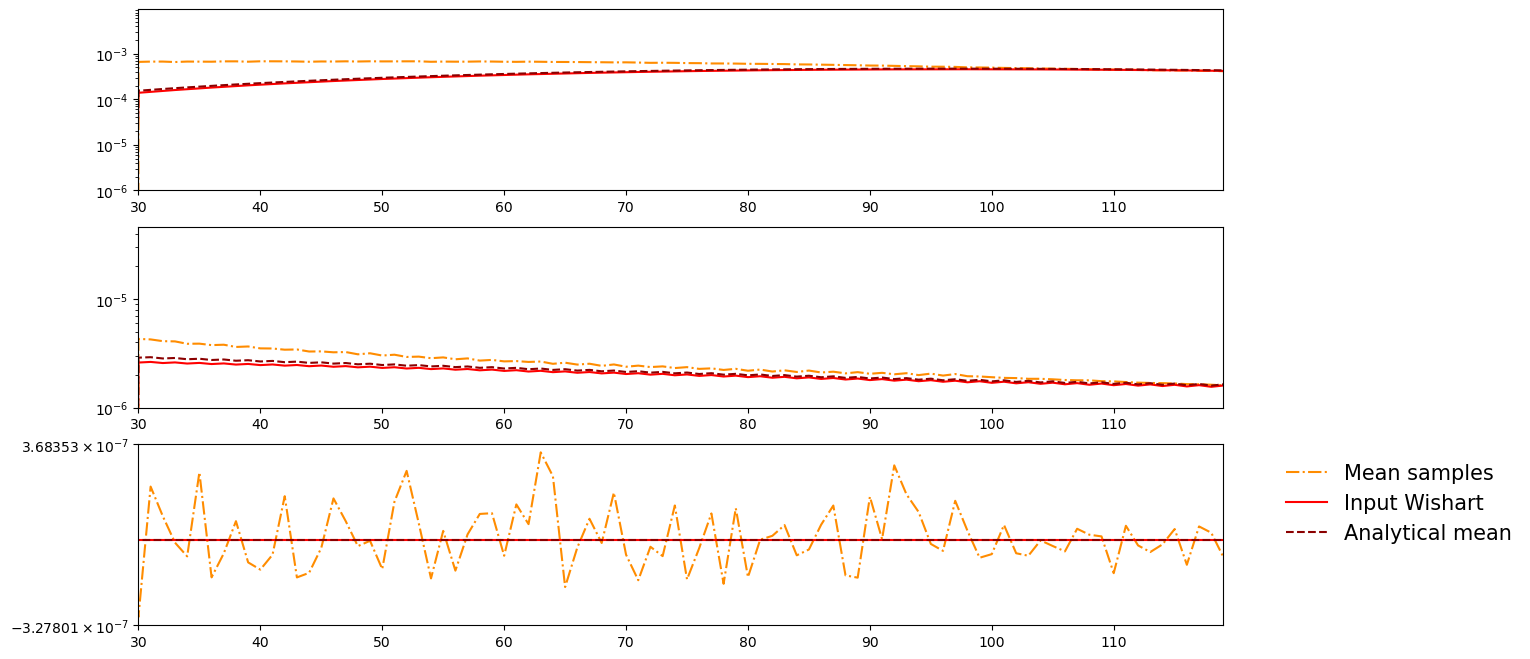

In [83]:
ell_arange = np.arange(lmax+1)

mean_c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells_list.mean(axis=0))
mean_c_ell_results_binned = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list.mean(axis=0))
# mean_c_ell_results_binned_v2 = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list_v2.mean(axis=0))

lmin_mean = 4
factor_ell = ((2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes))[lmin_mean:]

alpha_value = .5

plt.figure(figsize=(14,8))
for j in range(number_correl_to_plot):
    plt.subplot(311+j)    
    
    plt.plot(ell_arange[lmin_mean:], mean_c_ell_results[j,lmin_mean:]/factor_ell, '-.', color='darkorange', label='Mean samples')
    # plt.plot(ell_arange[lmin_mean:], mean_c_ell_results_scipy[j,lmin_mean:]/factor_ell, '-.', color='steelblue', label='Mean samples Scipy')
    
    plt.plot(ell_arange, c_ells_Wishart_runs[j,:], color='red', label='Input Wishart')
    plt.plot(ell_arange[lmin_mean:], c_ells_Wishart_runs[j,lmin_mean:]*factor_ell, '--', color='darkred', label='Analytical mean')

    
    # plt.xscale('log')
    if j <= nstokes-1:
        plt.yscale('log')
        plt.ylim(ymin=1e-6)
    else:
        plt.yscale('symlog')
    plt.xlim(xmin=lmin, xmax=MICMAC_sampler_obj.bin_ell_distribution[-1]-1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
plt.show()

In [92]:
ell_arange = np.arange(lmax+1)

mean_c_ell_results = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_cells_list.mean(axis=0))
mean_c_ell_results_binned = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list.mean(axis=0))
# mean_c_ell_results_binned_v2 = micmac.get_c_ells_from_red_covariance_matrix(red_invWishart_binned_cells_list_v2.mean(axis=0))

lmin_mean = 4
factor_ell = ((2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes))[lmin_mean:]

all_number_dof = MICMAC_sampler_obj.bin_ell_distribution[1:]**2 - MICMAC_sampler_obj.bin_ell_distribution[:-1]**2
factor_ell_bin = 1/(all_number_dof - 2 - 2*MICMAC_sampler_obj.nstokes)
# bmin_mean = 

bin_Wishart_mean = np.zeros((MICMAC_sampler_obj.number_correlations, nb_bin))
spectra_to_bin = (c_ells_Wishart_runs*(2*ell_arange+1))[...,MICMAC_sampler_obj.lmin:]
ell_factor_sum = np.zeros(nb_bin)
for i in range(nb_bin):
    bin_Wishart_mean[:,i] = spectra_to_bin[:,i*delta_ell:(i+1)*delta_ell].sum(axis=-1)
    ell_factor_sum[i] = (2*ell_arange[i*delta_ell:(i+1)*delta_ell]+1).sum()

# binned_ell = np.arange(mean_c_ell_results_binned.shape[-1])*delta_ell + (delta_ell-1)/2 + lmin
binned_ell = np.arange(mean_c_ell_results_binned.shape[-1])

# attempt_factor_ell_bin = (2*binned_ell+1)/(all_number_dof - 2 - 2*MICMAC_sampler_obj.nstokes)
attempt_factor_ell_bin = ell_factor_sum/(all_number_dof - 2 - 2*MICMAC_sampler_obj.nstokes)

alpha_value = .5

plt.figure(figsize=(14,8))
for j in range(number_correl_to_plot):
    plt.subplot(311+j)    
    
    # plt.plot(ell_arange[lmin_mean:], mean_c_ell_results[j,lmin_mean:]/factor_ell, '-.', color='darkorange', label='Mean samples')
    # plt.plot(ell_arange[lmin_mean:], mean_c_ell_results_scipy[j,lmin_mean:]/factor_ell, '-.', color='steelblue', label='Mean samples Scipy')
    plt.plot(binned_ell, mean_c_ell_results_binned[j,:], '-.', color='darkmagenta', label='Mean samples binned')
    # plt.plot(ell_arange, mean_c_ell_results_binned_v2[j,:], '-.', color='steelblue', label='Mean samples binned')
    
    plt.plot(ell_arange, c_ells_Wishart_runs[j,:], color='red', label='Input Wishart')
    # plt.plot(ell_arange[lmin_mean:], c_ells_Wishart_runs[j,lmin_mean:]*factor_ell, '--', color='darkred', label='Analytical mean')

    # plt.plot(binned_ell, bin_Wishart_mean[j,:]*factor_ell_bin, '--', color='darkred', label='Analytical mean binned')
    # plt.plot(MICMAC_sampler_obj.bin_ell_distribution[1:], bin_Wishart_mean[j,:], '--', color='darkred', label='Analytical mean binned')

    
    # plt.xscale('log')
    if j <= nstokes-1:
        plt.yscale('log')
        plt.ylim(ymin=1e-6)
    else:
        plt.yscale('symlog')
    plt.xlim(xmin=lmin, xmax=MICMAC_sampler_obj.bin_ell_distribution[-1]-1)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
plt.show()

/var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_87533/2518011215.py:51: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.xlim(xmin=lmin, xmax=MICMAC_sampler_obj.bin_ell_distribution[-1]-1)


In [ ]:
attempt_factor_ell_bin

Array([0.66666667, 0.85714286, 0.90909091, 0.93333333, 0.94736842,
       0.95652174, 0.96296296, 0.96774194, 0.97142857, 0.97435897,
       0.97674419, 0.9787234 , 0.98039216, 0.98181818, 0.98305085,
       0.98412698, 0.98507463, 0.98591549, 0.98666667, 0.98734177,
       0.98795181, 0.98850575, 0.98901099, 0.98947368, 0.98989899,
       0.99029126, 0.99065421, 0.99099099, 0.99130435, 0.99159664,
       0.99186992, 0.99212598, 0.99236641, 0.99259259, 0.99280576,
       0.99300699, 0.99319728, 0.99337748, 0.99354839, 0.99371069,
       0.99386503, 0.99401198, 0.99415205, 0.99428571, 0.99441341,
       0.99453552, 0.99465241, 0.9947644 , 0.99487179, 0.99497487,
       0.99507389, 0.99516908, 0.99526066, 0.99534884, 0.99543379,
       0.9955157 , 0.99559471, 0.995671  , 0.99574468, 0.9958159 ,
       0.99588477, 0.99595142, 0.99601594], dtype=float64)

In [ ]:
factor_ell

array([3.        , 2.2       , 1.85714286, 1.66666667, 1.54545455,
       1.46153846, 1.4       , 1.35294118, 1.31578947, 1.28571429,
       1.26086957, 1.24      , 1.22222222, 1.20689655, 1.19354839,
       1.18181818, 1.17142857, 1.16216216, 1.15384615, 1.14634146,
       1.13953488, 1.13333333, 1.12765957, 1.12244898, 1.11764706,
       1.11320755, 1.10909091, 1.10526316, 1.10169492, 1.09836066,
       1.0952381 , 1.09230769, 1.08955224, 1.08695652, 1.08450704,
       1.08219178, 1.08      , 1.07792208, 1.07594937, 1.07407407,
       1.07228916, 1.07058824, 1.06896552, 1.06741573, 1.06593407,
       1.06451613, 1.06315789, 1.06185567, 1.06060606, 1.05940594,
       1.05825243, 1.05714286, 1.05607477, 1.05504587, 1.05405405,
       1.05309735, 1.05217391, 1.05128205, 1.05042017, 1.04958678,
       1.04878049, 1.048     , 1.04724409, 1.04651163, 1.04580153,
       1.04511278, 1.04444444, 1.04379562, 1.04316547, 1.04255319,
       1.04195804, 1.04137931, 1.04081633, 1.04026846, 1.03973

In [ ]:
all_number_dof - 2 - 2*MICMAC_sampler_obj.nstokes

Array([  6,  14,  22,  30,  38,  46,  54,  62,  70,  78,  86,  94, 102,
       110, 118, 126, 134, 142, 150, 158, 166, 174, 182, 190, 198, 206,
       214, 222, 230, 238, 246, 254, 262, 270, 278, 286, 294, 302, 310,
       318, 326, 334, 342, 350, 358, 366, 374, 382, 390, 398, 406, 414,
       422, 430, 438, 446, 454, 462, 470, 478, 486, 494, 502],      dtype=int64)